# Demo 3: Classification with Naivebayes model

This demo we will demo code for using Naivebayes model to solve the classification problem:
-   Problem: Defect detection classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library package:
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree,...)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    
Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in Scikit-Learn can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set)
## 1. Task 1: Getting model from scikit-learn:
-   naivebayes: "Gaussian", "Multinomial", "Bernoulli",...
-   Training model on our trainset
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,... 
-   Comparing different distribution model in naivebayes to get the better model:
## 3. Task 3: Evaluating the performance of model by Cross Validation method.
*****************************************************************************

# Import all packages

In [90]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from sklearn import naive_bayes
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import pandas as pd

## 0. Task 0: Preparing Dataset
Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [91]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)

### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [92]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [93]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 28
height = 28
X,y = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)

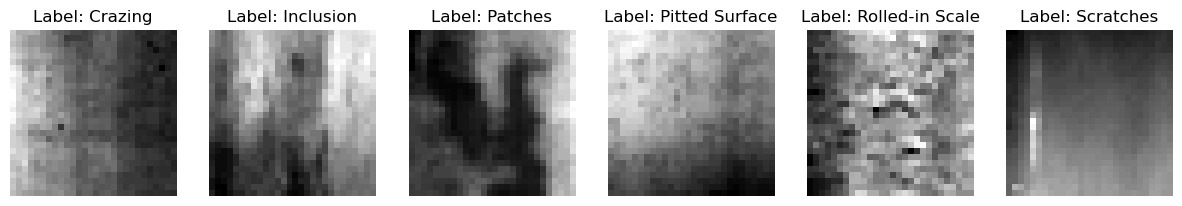

In [94]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(y,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[y[index]]}")

### Note!
The shape of data for KNN model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 28 x 28 pixels. Each pixels is one feature of sample, so totally we have 28*28 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)

In [95]:
print("The currently shape of input dataset X is:", X.shape)
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))

The currently shape of input dataset X is: (1800, 28, 28)


In [96]:
print("The currently shape of input dataset X is:", X.shape)

The currently shape of input dataset X is: (1800, 784)


### 0.4. Deviding our dataset to trainset and testset

In [97]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [98]:
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 1440
Number of samples in the test subset: 360


## 1. Task 1: Getting model from scikit-laern
### 1.1. Getting Gaussian model from naivebayes in scikit-learn
-   References: [https://scikit-learn.org/stable/modules/naive_bayes.html](Different distributions)


In [99]:
# Create a Gaussian model:
gaussian_NB = naive_bayes.GaussianNB()

### 1.2. Training for our model (fitting data to our model)

In [100]:
# Training for our gaussian model:
gaussian_NB.fit(X_train,y_train)

GaussianNB()

## 2. Task 2: Evaluating the performance of trained model on the testset
### 2.1 Predict the label (which class) for each input image in the testset

In [101]:
pred_test = gaussian_NB.predict(X_test)

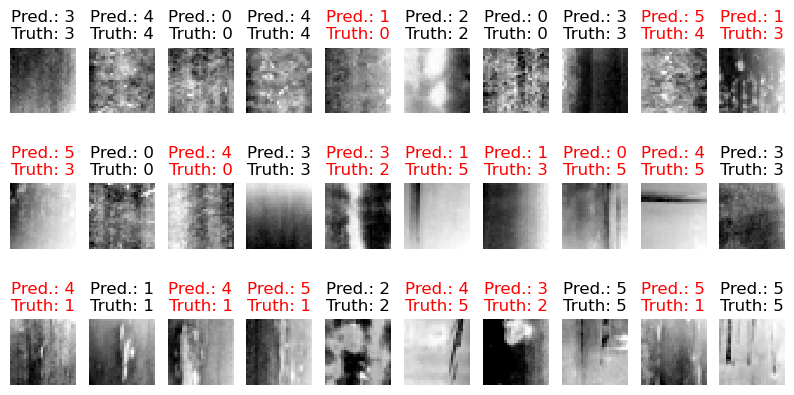

In [102]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = y_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

### 2.2. Compute the metrics (quantitative measurements)

Text(0.5, 0.98, 'Number occurrences of each class on test set')

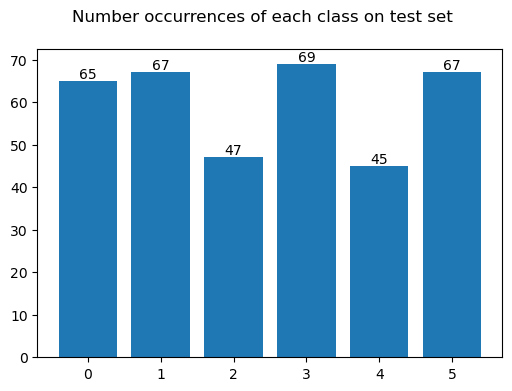

In [103]:
nb_classes = len(np.unique(y_test))
## Visual bar plot of number occurrences of each class in testset:
statistic_class = np.unique(y_test,return_counts=True)
categoricalClasses = [f'{C}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [104]:
# Classification report:
print(f"Classification report for classifier {gaussian_NB}:\n"
      f"{metrics.classification_report(y_test,pred_test,digits=4)}\n")

Classification report for classifier GaussianNB():
              precision    recall  f1-score   support

           0     0.4375    0.5385    0.4828        65
           1     0.0625    0.0149    0.0241        67
           2     1.0000    0.5532    0.7123        47
           3     0.6724    0.5652    0.6142        69
           4     0.3333    0.4889    0.3964        45
           5     0.3947    0.6716    0.4972        67

    accuracy                         0.4667       360
   macro avg     0.4834    0.4721    0.4545       360
weighted avg     0.4652    0.4667    0.4445       360




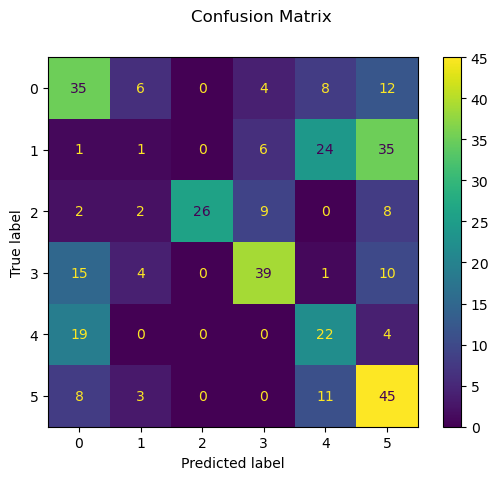

In [105]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

### 2.3. Comparision of different distribution model in Naivebayes 

In [106]:
# There are some metric for evaluation performance of model
def evaluation_model(model,
                     X_train,
                     y_train,
                     X_test,
                     y_test):
    model.fit(X_train,y_train)
    pred_test = model.predict(X_test)
    report = metrics.classification_report(y_test,pred_test,digits = 4, output_dict = True)
    return (report['macro avg'],report['weighted avg'])

Create a dict to store results from different distribution model

In [107]:
marco_avg_all = {}
weighted_avg_all = {}
models = [naive_bayes.GaussianNB(),
          naive_bayes.MultinomialNB(),
          naive_bayes.BernoulliNB(),
          naive_bayes.ComplementNB(),
          naive_bayes.CategoricalNB()]
distributions = ["Gaussian",
                 "Multinomial",
                 "Bernoulli",
                 "Complement",
                 "Categorical"]
for i in range(len(models)):
    result = evaluation_model(model=models[i],
                              X_train=X_train,
                              y_train=y_train,
                              X_test=X_test,
                              y_test=y_test)
    marco_avg_all[distributions[i]] = result[0]
    weighted_avg_all[distributions[i]] = result[1]


/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [108]:
print(list(marco_avg_all["Complement"].keys()))

['precision', 'recall', 'f1-score', 'support']


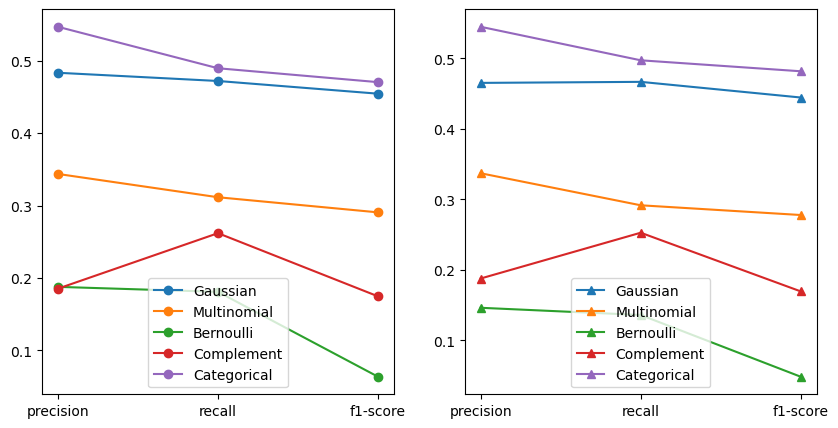

In [109]:
# Plot results
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
x_tickers = list(marco_avg_all["Gaussian"].keys())[:3]
fig,axes = plt.subplots(nrows = 1, ncols = 2,
                      figsize = (10,5))
for type in distributions:
    axes[0].plot(x_tickers,
                   np.array([i for i in marco_avg_all[type].values()])[:3],
                   marker = 'o',
                   label = type)
    axes[1].plot(x_tickers,
                   np.array([i for i in weighted_avg_all[type].values()])[:3],
                   marker = "^",
                   label = type)
axes[0].legend(frameon = True)
axes[1].legend(frameon = True)
plt.show()


## 3. Task 3: Evaluating the performances of model by Cross Validation
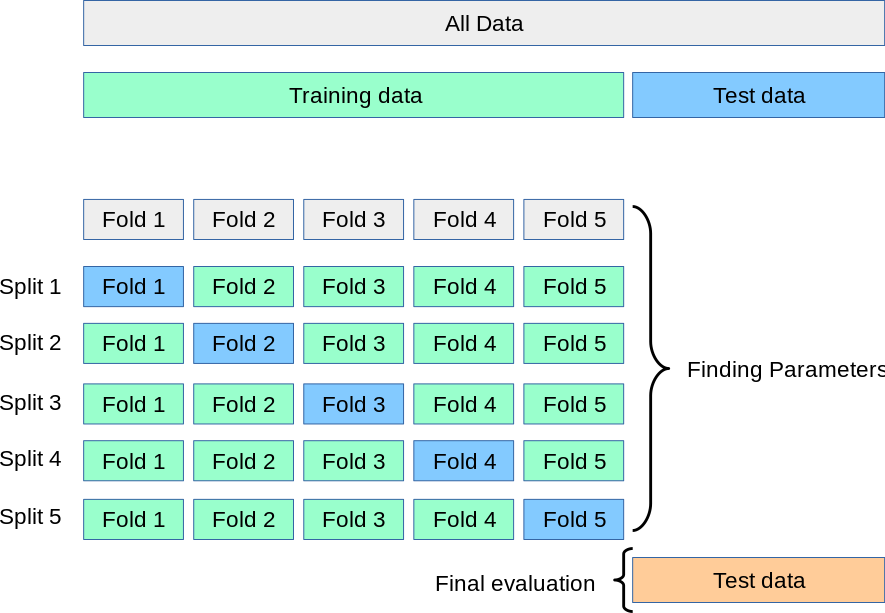

-   Define an evaluate function to compute the accuracy sores on each split step. 
-   Each step will have its own accuracy sore.
-   Number of split step equal to the number of folds 
-   We can repeat this step to get the stability of the accuracy score.

In [110]:
models = [naive_bayes.GaussianNB(),
          naive_bayes.MultinomialNB(),
          naive_bayes.BernoulliNB(),
          naive_bayes.ComplementNB()]
distributions = ["Gaussian",
                 "Multinomial",
                 "Bernoulli",
                 "Complement"]

In [111]:
def evaluate_NB_CrossVal(NBmodel,
                         X,y,
                         kfold: int = 10,
                         n_repeats:int  = 5,
                         random_state: int = 1):
    cv = RepeatedStratifiedKFold(n_splits=kfold,
                                 n_repeats=n_repeats,
                                 random_state=random_state)
    return cross_val_score(NBmodel,X,y,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=1,
                           error_score='raise')

In [112]:
score_holder = []
for i in range(len(models)):
    print(" Im in step: ",i)
    score_holder.append(evaluate_NB_CrossVal(NBmodel=models[i],
                                             X = X, y = y))

 Im in step:  0
 Im in step:  1
 Im in step:  2
 Im in step:  3


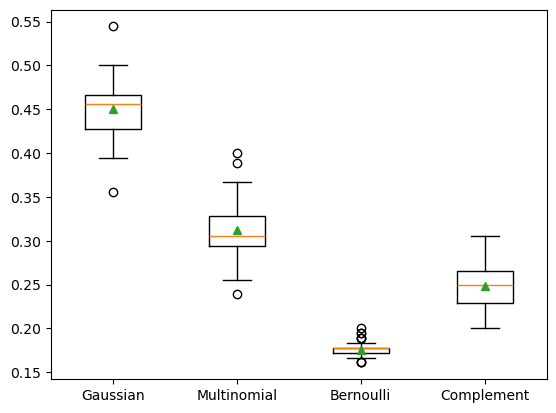

In [113]:
plt.boxplot(score_holder,labels=distributions,showmeans=True)
plt.show()

# Select the best model in naivebayes
-   Gaussian NB